In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# For ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose      
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse

# For determining ARIMA hyperparameters
from pmdarima import auto_arima                              

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Raw data

In [2]:
# *
# Enter input paths for footfall data
path_footfall = 'C:/Users/medira/OneDrive - University of Leeds/Projects/AmbPop/AmbPopData/LCC_footfall_cleaned_2021.csv'

# Enter output paths for the folder storing outputs
dir_out = '../AmbPop_Outputs/'

In [3]:
# *
# Load footfall data to pandas DataFrame
df_footfall = pd.read_csv(path_footfall, index_col='DateTime', parse_dates=True)

df_footfall['Date'] = pd.to_datetime(df_footfall['Date'])
df_footfall['Year'] = df_footfall.Date.dt.year
df_footfall['Month'] = df_footfall.Date.dt.month
df_footfall['Hour'] = df_footfall.Date.dt.hour
df_footfall['YearMonth'] = df_footfall.Date.dt.to_period('M')
df_footfall['MonthDay'] = df_footfall.Date.dt.day
df_footfall['WeekDay'] = df_footfall.Date.dt.weekday
df_footfall['WeekDayName'] = df_footfall.Date.dt.day_name()
df_footfall['IsWeekend'] = df_footfall.WeekDay > 4
df_footfall['YearMonthDay'] = df_footfall['Year'].astype(str) + '-' + df_footfall['MonthDay'].astype(str)
df_footfall['YearWeekDay'] = df_footfall['Year'].astype(str) + '-' + df_footfall['WeekDay'].astype(str)
df_footfall['YearMonthWeekDay'] = df_footfall['YearMonth'].astype(str) + '-' + df_footfall['WeekDay'].astype(str)
df_footfall['LocationYear'] = df_footfall['Location'].astype(str) + '-' + df_footfall['Year'].astype(str)
df_footfall['LocationYearMonth'] = df_footfall['Location'].astype(str) + '-' + df_footfall['YearMonth'].astype(str)


df_footfall = df_footfall[['Location', 'LocationYear', 'LocationYearMonth', 'Count', 'Date', 'Year', 'YearMonth', 'Month',
                           'YearMonthDay', 'MonthDay', 'YearWeekDay', 'WeekDay', 'YearMonthWeekDay',
                           'WeekDayName', 'IsWeekend', 'BRCWeekNum', 'BRCMonthNum', 'BRCMonth', 'BRCYear']]

df_footfall.info()
df_footfall.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           793558 non-null  object        
 1   LocationYear       793558 non-null  object        
 2   LocationYearMonth  793558 non-null  object        
 3   Count              793558 non-null  int64         
 4   Date               793558 non-null  datetime64[ns]
 5   Year               793558 non-null  int64         
 6   YearMonth          793558 non-null  period[M]     
 7   Month              793558 non-null  int64         
 8   YearMonthDay       793558 non-null  object        
 9   MonthDay           793558 non-null  int64         
 10  YearWeekDay        793558 non-null  object        
 11  WeekDay            793558 non-null  int64         
 12  YearMonthWeekDay   793558 non-null  object        
 13  WeekDayNam

,Location,LocationYear,LocationYearMonth,Count,Date,Year,YearMonth,Month,YearMonthDay,MonthDay,YearWeekDay,WeekDay,YearMonthWeekDay,WeekDayName,IsWeekend,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear
DateTime,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,3,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 01:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,6,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 02:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,1,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 03:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,30,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 04:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,20,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020


In [4]:
# *
df_footfall.dropna(inplace=True)

df_footfall.info()
df_footfall.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           793558 non-null  object        
 1   LocationYear       793558 non-null  object        
 2   LocationYearMonth  793558 non-null  object        
 3   Count              793558 non-null  int64         
 4   Date               793558 non-null  datetime64[ns]
 5   Year               793558 non-null  int64         
 6   YearMonth          793558 non-null  period[M]     
 7   Month              793558 non-null  int64         
 8   YearMonthDay       793558 non-null  object        
 9   MonthDay           793558 non-null  int64         
 10  YearWeekDay        793558 non-null  object        
 11  WeekDay            793558 non-null  int64         
 12  YearMonthWeekDay   793558 non-null  object        
 13  WeekDayNam

,Location,LocationYear,LocationYearMonth,Count,Date,Year,YearMonth,Month,YearMonthDay,MonthDay,YearWeekDay,WeekDay,YearMonthWeekDay,WeekDayName,IsWeekend,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear
DateTime,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,3,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 01:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,6,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 02:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,1,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 03:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,30,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 04:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,20,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020


## Statistics

In [5]:
# *
df_footfall_stats = df_footfall[['Location', 'Count']]

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  793558 non-null  object
 1   Count     793558 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 18.2+ MB


,Location,Count
DateTime,,
2020-03-08 00:00:00,Albion Street South,3
2020-03-08 01:00:00,Albion Street South,6
2020-03-08 02:00:00,Albion Street South,1
2020-03-08 03:00:00,Albion Street South,30
2020-03-08 04:00:00,Albion Street South,20


In [6]:
# *
df_footfall_stats['NumRecords'] = df_footfall_stats.groupby('Location')['Location'].transform('count')

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Location    793558 non-null  object
 1   Count       793558 non-null  int64 
 2   NumRecords  793558 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.2+ MB


,Location,Count,NumRecords
DateTime,,,
2020-03-08 00:00:00,Albion Street South,3,104904
2020-03-08 01:00:00,Albion Street South,6,104904
2020-03-08 02:00:00,Albion Street South,1,104904
2020-03-08 03:00:00,Albion Street South,30,104904
2020-03-08 04:00:00,Albion Street South,20,104904


In [7]:
# *
df_footfall_stats = df_footfall_stats[df_footfall_stats['NumRecords'] == 104904]
df_footfall_stats.drop('NumRecords', axis=1, inplace=True)

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  629424 non-null  object
 1   Count     629424 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ MB


,Location,Count
DateTime,,
2020-03-08 00:00:00,Albion Street South,3
2020-03-08 01:00:00,Albion Street South,6
2020-03-08 02:00:00,Albion Street South,1
2020-03-08 03:00:00,Albion Street South,30
2020-03-08 04:00:00,Albion Street South,20


In [8]:
df_footfall_stats.sort_index(inplace=True)

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2008-01-09 00:00:00 to 2021-12-04 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  629424 non-null  object
 1   Count     629424 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ MB


,Location,Count
DateTime,,
2008-01-09,Briggate,115
2008-01-09,Commercial Street Combined,20
2008-01-09,Dortmund Square,14
2008-01-09,Briggate at McDonalds,28
2008-01-09,Headrow,8


In [9]:
# *
df_footfall_stats = df_footfall_stats.loc[pd.Timestamp('2008-01-01'):pd.Timestamp('2020-01-01')]

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560166 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  560166 non-null  object
 1   Count     560166 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.8+ MB


,Location,Count
DateTime,,
2008-01-09,Briggate,115
2008-01-09,Commercial Street Combined,20
2008-01-09,Dortmund Square,14
2008-01-09,Briggate at McDonalds,28
2008-01-09,Headrow,8


In [10]:
# *
df_footfall_stats.groupby('Location').describe()

Count                                        \
                              count         mean          std  min    25%   
Location                                                                    
Albion Street South         93361.0  1079.845385  1581.380841  0.0   79.0   
Briggate                    93361.0  1395.384208  1712.852546  0.0  217.0   
Briggate at McDonalds       93361.0   637.965446   650.727155  0.0   97.0   
Commercial Street Combined  93361.0  1151.281049  1627.860822  0.0   66.0   
Dortmund Square             93361.0   970.176316  1157.347395  0.0   89.0   
Headrow                     93361.0   670.190540   760.629163  0.0   74.0   

                                                    
                              50%     75%      max  
Location                                            
Albion Street South         367.0  1606.0  23268.0  
Briggate                    614.0  2134.0  19820.0  
Briggate at McDonalds       360.0  1101.0   5652.0  
Commercial Street Combined  311.0  1870.0  19745.0  
Dortmund Square             445.0  1609.0  10073.0  
Headrow                     320.0  1150.0   6717.0

In [11]:
# *
location_list = df_footfall_stats['Location'].unique()

df_footfall_stats_dict = {loc : pd.DataFrame() for loc in location_list}

for key in df_footfall_stats_dict.keys():
    df_footfall_stats_dict[key] = df_footfall_stats[:][df_footfall_stats['Location'] == key]
    df_footfall_stats_dict[key].drop('Location', axis=1, inplace=True)
    
df_footfall_stats_dict['Headrow'].info()
df_footfall_stats_dict['Headrow'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93361 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   93361 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


,Count
DateTime,
2008-01-09 00:00:00,8
2008-01-09 01:00:00,9
2008-01-09 02:00:00,3
2008-01-09 03:00:00,6
2008-01-09 04:00:00,8


Location: Briggate


<Figure size 432x288 with 0 Axes>

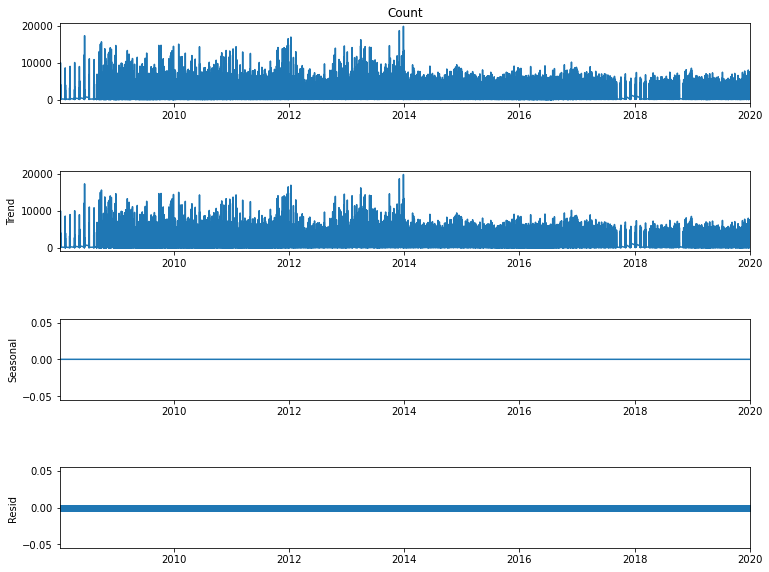

Location: Commercial Street Combined


<Figure size 432x288 with 0 Axes>

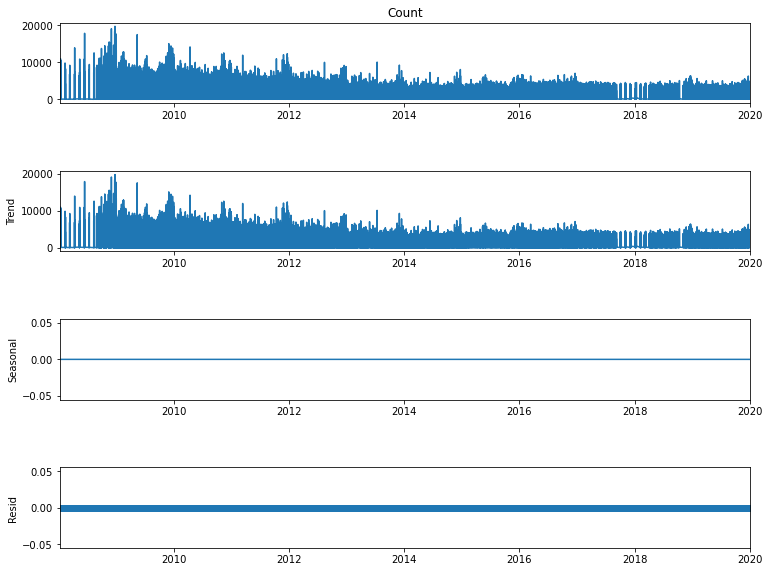

Location: Dortmund Square


<Figure size 432x288 with 0 Axes>

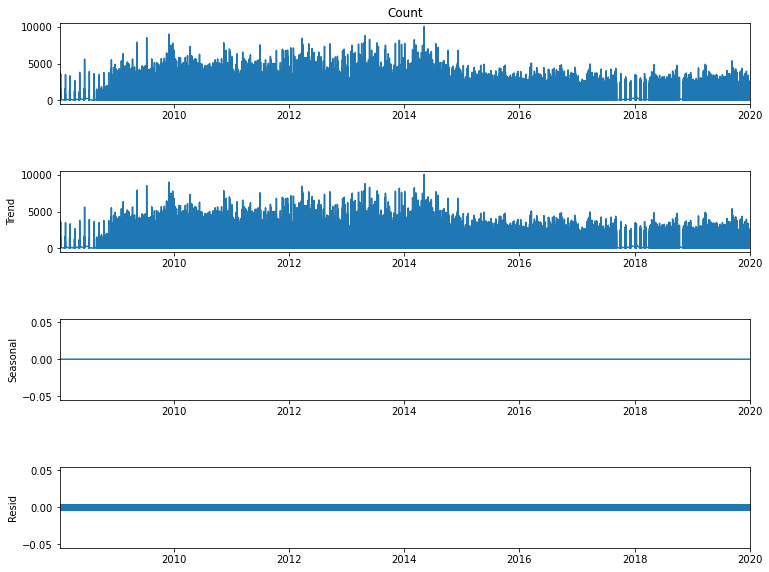

Location: Briggate at McDonalds


<Figure size 432x288 with 0 Axes>

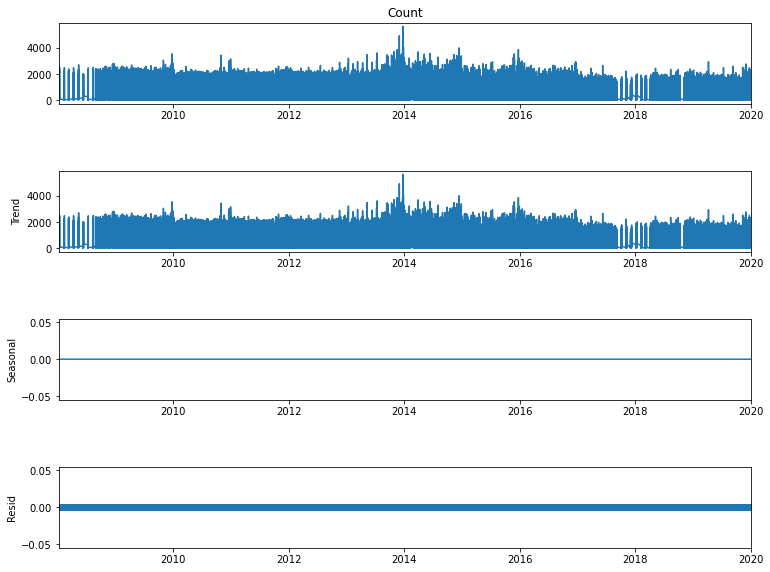

Location: Headrow


<Figure size 432x288 with 0 Axes>

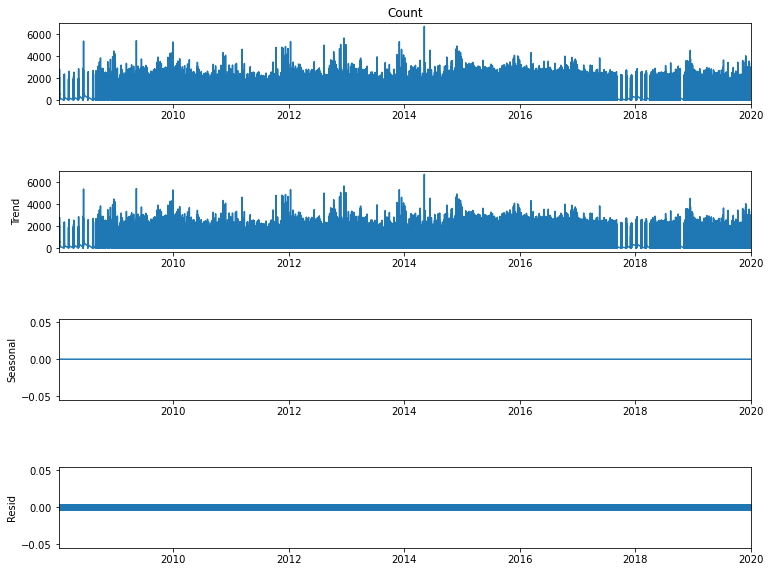

Location: Albion Street South


<Figure size 432x288 with 0 Axes>

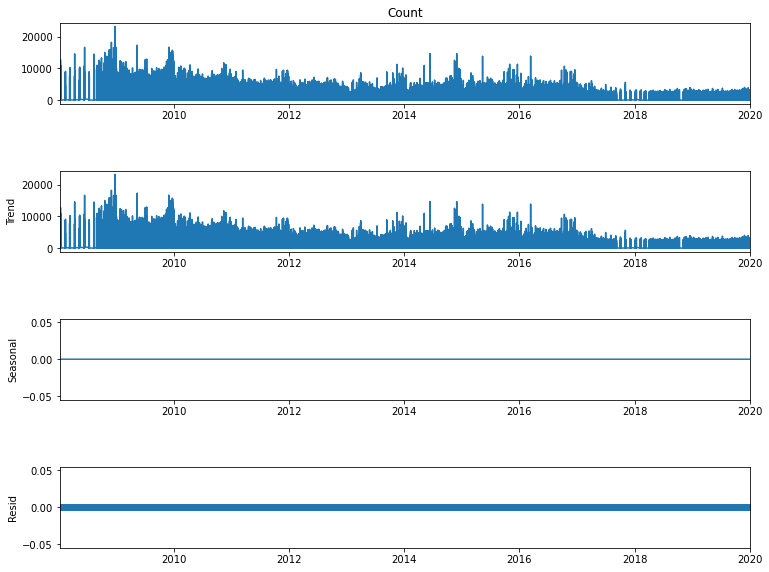

In [12]:
# *
for key in df_footfall_stats_dict.keys():
    result = seasonal_decompose(df_footfall_stats_dict[key]['Count'], period=1)
    print('Location: ' + key)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(12, 9)
    plt.show()

In [13]:
# *
from statsmodels.tsa.stattools import adfuller

def plot(ts, name, sec, choice):
    
    plt.rcParams["figure.figsize"] = (15,10)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot(ts, color='blue',label='Original')
    
    if 'rolmean' in choice:
        rolmean = ts.rolling(sec).mean()
        plt.plot(rolmean, color='red', label='Rolling Mean')
    if 'rolstd' in choice:
        rolstd = ts.rolling(sec).std()
        plt.plot(rolstd, color='black', label = 'Rolling Std')
    if 'expmean' in choice:
        expmean = ts.ewm(sec).mean()
        eplt.plot(expmean, color='green', label = 'Exp Mean')
        
        
    plt.legend(loc='best')
    ax.set_ylabel('Count')
    ax.set_xlabel('DateTime')
    plt.title(str(name), fontsize=15)
    ax.tick_params(axis='x', rotation=45)
    plt.show()

def test_stationarity(ts, name, sec, choice):
    
    plot(ts, name, sec, choice)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

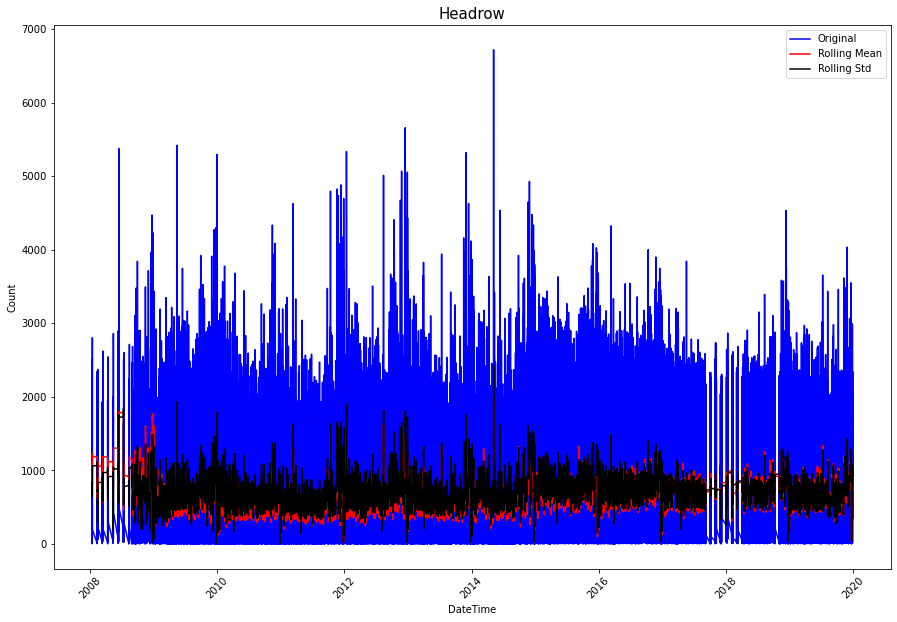

Results of Dickey-Fuller Test:
Test Statistic                   -24.519891
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    93293.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64


In [14]:
test_stationarity(df_footfall_stats_dict['Headrow'], 'Headrow', 24, set(['rolmean', 'rolstd']))

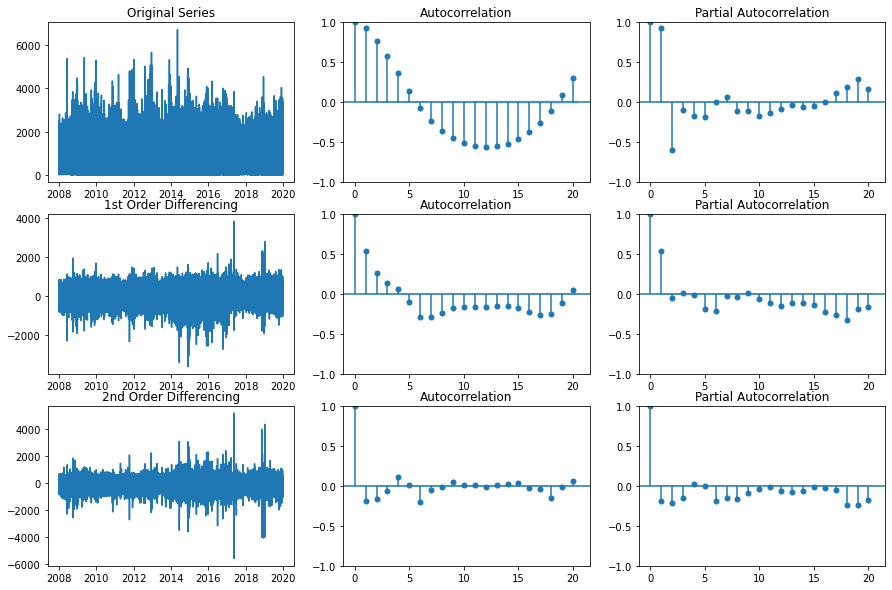

In [15]:
# *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(df_footfall_stats_dict['Headrow']); axes[0, 0].set_title('Original Series')
plot_acf(df_footfall_stats_dict['Headrow'], ax=axes[0, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'], ax=axes[0, 2], lags=20)

# 1st Differencing
axes[1, 0].plot(df_footfall_stats_dict['Headrow'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_footfall_stats_dict['Headrow'].diff().dropna(), ax=axes[1, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'].diff().dropna(), ax=axes[1, 2], lags=20)


# 2nd Differencing
axes[2, 0].plot(df_footfall_stats_dict['Headrow'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_footfall_stats_dict['Headrow'].diff().diff().dropna(), ax=axes[2, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'].diff().diff().dropna(), ax=axes[2, 2], lags=20)

plt.show()

In [16]:
#*
from pmdarima.arima.utils import ndiffs

## Adf Test
#ndiffs(df_footfall_stats_dict['Headrow'], test='adf')  #0

# KPSS test
#ndiffs(df_footfall_stats_dict['Headrow'], test='kpss')  #1

# PP test:
#ndiffs(df_footfall_stats_dict['Headrow'], test='pp') #0

In [17]:
# *
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_footfall_stats_dict['Headrow'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                93361
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -646970.967
Date:                Mon, 22 Aug 2022   AIC                        1293949.934
Time:                        02:45:44   BIC                        1293987.711
Sample:                             0   HQIC                       1293961.434
                              - 93361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        670.1903     14.797     45.292      0.000     641.188     699.192
ar.L1          0.8806      0.002    568.804      0.000       0.878       0.884
ma.L1          0.4971      0.002    313.474      0.0

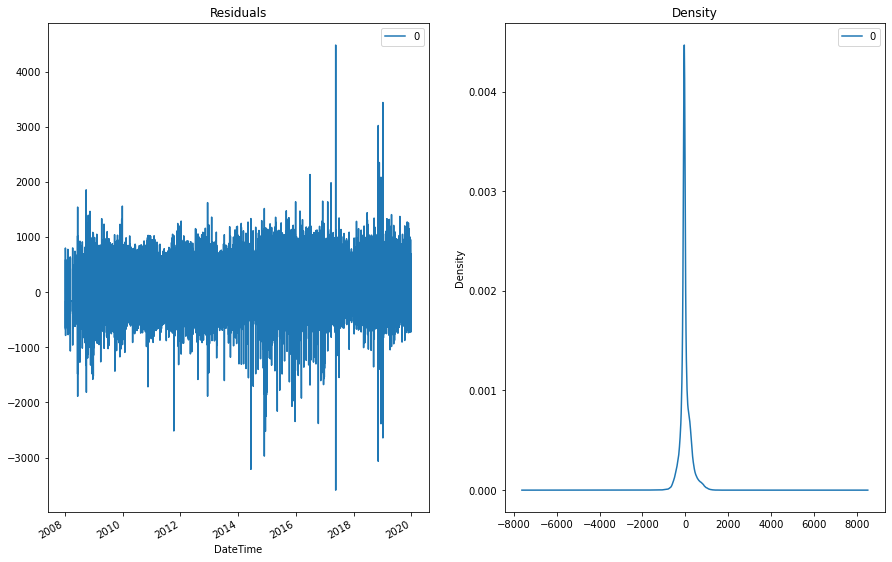

In [18]:
# *
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

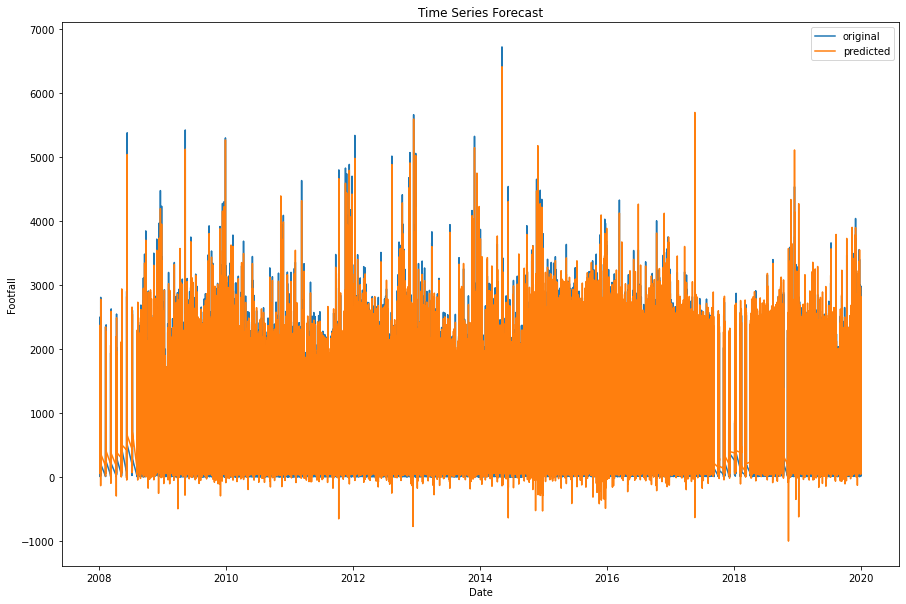

In [19]:
# *
forecast = model_fit.predict()

fig, ax = plt.subplots(1, 1)
plt.plot(df_footfall_stats_dict['Headrow'], label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

In [20]:
# *
df_footfall_stats_dict['Albion Street South'].info()
df_footfall_stats_dict['Albion Street South'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93361 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   93361 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


,Count
DateTime,
2008-01-09 00:00:00,30
2008-01-09 01:00:00,3
2008-01-09 02:00:00,6
2008-01-09 03:00:00,16
2008-01-09 04:00:00,1


In [21]:
# *
df_footfall_stats_dict['Albion Street South'][df_footfall_stats_dict['Albion Street South']['Count'].isna()]

,Count
DateTime,


In [22]:
# *
time_list=pd.date_range(start='1/9/2008', end='1/1/2020', freq='H')
print(time_list)

DatetimeIndex(['2008-01-09 00:00:00', '2008-01-09 01:00:00',
               '2008-01-09 02:00:00', '2008-01-09 03:00:00',
               '2008-01-09 04:00:00', '2008-01-09 05:00:00',
               '2008-01-09 06:00:00', '2008-01-09 07:00:00',
               '2008-01-09 08:00:00', '2008-01-09 09:00:00',
               ...
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-31 22:00:00',
               '2019-12-31 23:00:00', '2020-01-01 00:00:00'],
              dtype='datetime64[ns]', length=105001, freq='H')


In [23]:
# *
df_footfall_stats_dict['Albion Street South'] = df_footfall_stats_dict['Albion Street South'].reindex(time_list, fill_value=np.nan)
df_footfall_stats_dict['Albion Street South'].info()
df_footfall_stats_dict['Albion Street South'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105001 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Count   93361 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


,Count
2008-01-09 00:00:00,30.0
2008-01-09 01:00:00,3.0
2008-01-09 02:00:00,6.0
2008-01-09 03:00:00,16.0
2008-01-09 04:00:00,1.0


In [24]:
# *
df_footfall_stats_dict['Albion Street South'][df_footfall_stats_dict['Albion Street South']['Count'].isna()]

,Count
2008-01-13 00:00:00,NaN
2008-01-13 01:00:00,NaN
2008-01-13 02:00:00,NaN
2008-01-13 03:00:00,NaN
2008-01-13 04:00:00,NaN
...,...
2018-12-10 19:00:00,NaN
2018-12-10 20:00:00,NaN
2018-12-10 21:00:00,NaN
2018-12-10 22:00:00,NaN


In [25]:
# *
model_nan = ARIMA(df_footfall_stats_dict['Albion Street South']['Count'], order=(1,0,1))
model_nan_fit = model_nan.fit()
print(model_nan_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:               105001
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -735239.899
Date:                Mon, 22 Aug 2022   AIC                        1470487.798
Time:                        02:47:09   BIC                        1470526.045
Sample:                    01-09-2008   HQIC                       1470499.379
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1079.7996     25.276     42.720      0.000    1030.259    1129.341
ar.L1          0.8146      0.001    741.980      0.000       0.812       0.817
ma.L1          0.5038      0.001    345.080      0.0

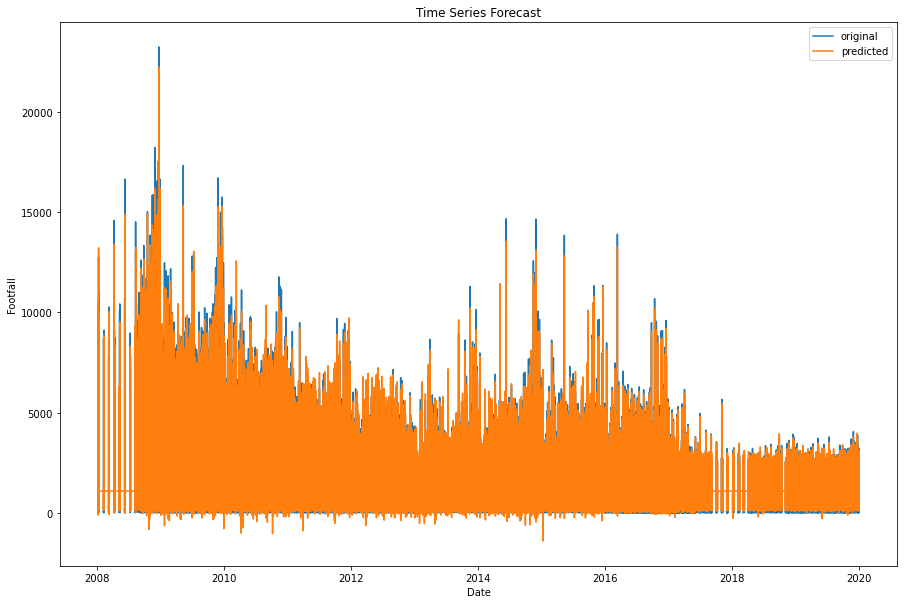

In [26]:
# *
forecast_nan = model_nan_fit.predict()

fig, ax = plt.subplots(1, 1)
plt.plot(df_footfall_stats_dict['Albion Street South'], label = "original")
plt.plot(forecast_nan, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

In [27]:
train_na = df_footfall_stats_dict['Albion Street South'].loc[:pd.Timestamp('2019-01-01')]
test_na = df_footfall_stats_dict['Albion Street South'].loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')]
actual_na = df_footfall_stats_dict['Albion Street South'].loc[:pd.Timestamp('2019-01-02')]

In [28]:
train_na.tail(5)

,Count
2018-12-31 20:00:00,130.0
2018-12-31 21:00:00,200.0
2018-12-31 22:00:00,148.0
2018-12-31 23:00:00,121.0
2019-01-01 00:00:00,143.0


In [29]:
test_na.head(25)

,Count
2019-01-01 01:00:00,136.0
2019-01-01 02:00:00,100.0
2019-01-01 03:00:00,57.0
2019-01-01 04:00:00,59.0
2019-01-01 05:00:00,25.0
2019-01-01 06:00:00,17.0
2019-01-01 07:00:00,30.0
2019-01-01 08:00:00,64.0
2019-01-01 09:00:00,104.0
2019-01-01 10:00:00,173.0


In [30]:
model_na_fc = ARIMA(train_na, order=(1, 0, 1))  
model_na_fc_fit = model_na_fc.fit()  

In [31]:
# Forecast
fc = model_na_fc_fit.forecast(24)

In [32]:
print(fc)

2019-01-01 01:00:00     265.303471
2019-01-01 02:00:00     423.265836
2019-01-01 03:00:00     551.662155
2019-01-01 04:00:00     656.026348
2019-01-01 05:00:00     740.856542
2019-01-01 06:00:00     809.808945
2019-01-01 07:00:00     865.855426
2019-01-01 08:00:00     911.411605
2019-01-01 09:00:00     948.440968
2019-01-01 10:00:00     978.539491
2019-01-01 11:00:00    1003.004429
2019-01-01 12:00:00    1022.890230
2019-01-01 13:00:00    1039.053975
2019-01-01 14:00:00    1052.192329
2019-01-01 15:00:00    1062.871558
2019-01-01 16:00:00    1071.551941
2019-01-01 17:00:00    1078.607603
2019-01-01 18:00:00    1084.342647
2019-01-01 19:00:00    1089.004254
2019-01-01 20:00:00    1092.793341
2019-01-01 21:00:00    1095.873220
2019-01-01 22:00:00    1098.376633
2019-01-01 23:00:00    1100.411478
2019-01-02 00:00:00    1102.065459
Freq: H, Name: predicted_mean, dtype: float64


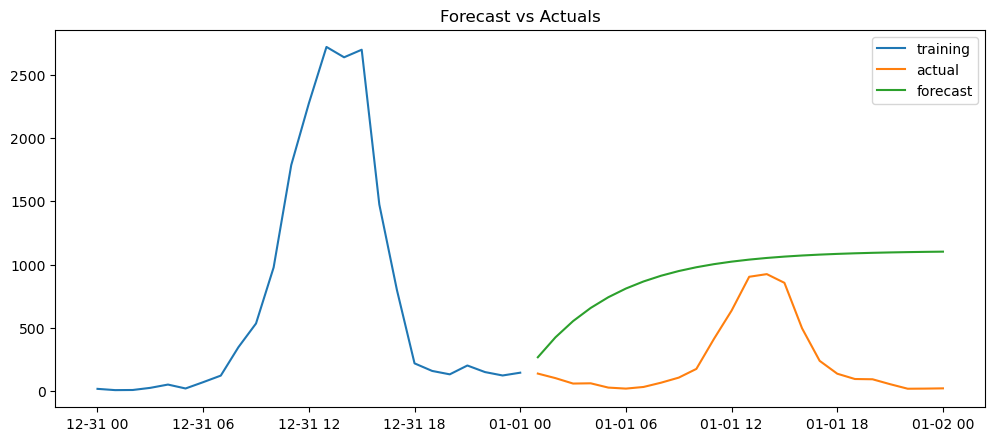

In [33]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_na.loc[pd.Timestamp('2018-12-31'): pd.Timestamp('2019-01-01')], label='training')
plt.plot(test_na.loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')], label='actual')
plt.plot(fc.loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

use one month before for predicting one day (apply accordingly)
seasonality - sarima (have diff seasonalities (hourly, monthly...), arima x no seasonality)
exogenous variables before adding seasonality (careful with misinfo)

In [34]:
train_mnth_na = df_footfall_stats_dict['Albion Street South'].loc[pd.Timestamp('2019-01-01'):pd.Timestamp('2019-02-01')]
test_mnth_na = df_footfall_stats_dict['Albion Street South'].loc[pd.Timestamp('2019-02-01'): pd.Timestamp('2019-02-02')]

In [35]:
train_mnth_na.tail(5)

,Count
2019-01-31 20:00:00,216.0
2019-01-31 21:00:00,88.0
2019-01-31 22:00:00,67.0
2019-01-31 23:00:00,23.0
2019-02-01 00:00:00,15.0


In [36]:
test_mnth_na.head(5)

,Count
2019-02-01 00:00:00,15.0
2019-02-01 01:00:00,5.0
2019-02-01 02:00:00,12.0
2019-02-01 03:00:00,41.0
2019-02-01 04:00:00,1.0


In [37]:
model_mnth_na_fc = ARIMA(train_mnth_na, order=(2, 0, 1))  
model_mnth_na_fc_fit = model_mnth_na_fc.fit()  

In [38]:
# Forecast
fc_mnth = model_mnth_na_fc_fit.forecast(24)

In [39]:
print(fc_mnth)

2019-02-01 01:00:00    110.693691
2019-02-01 02:00:00    234.459389
2019-02-01 03:00:00    342.358918
2019-02-01 04:00:00    428.179464
2019-02-01 05:00:00    494.505113
2019-02-01 06:00:00    545.267252
2019-02-01 07:00:00    583.986423
2019-02-01 08:00:00    613.484616
2019-02-01 09:00:00    635.948396
2019-02-01 10:00:00    653.052729
2019-02-01 11:00:00    666.075602
2019-02-01 12:00:00    675.990757
2019-02-01 13:00:00    683.539757
2019-02-01 14:00:00    689.287249
2019-02-01 15:00:00    693.663143
2019-02-01 16:00:00    696.994762
2019-02-01 17:00:00    699.531314
2019-02-01 18:00:00    701.462535
2019-02-01 19:00:00    702.932884
2019-02-01 20:00:00    704.052345
2019-02-01 21:00:00    704.904654
2019-02-01 22:00:00    705.553566
2019-02-01 23:00:00    706.047619
2019-02-02 00:00:00    706.423770
Freq: H, Name: predicted_mean, dtype: float64


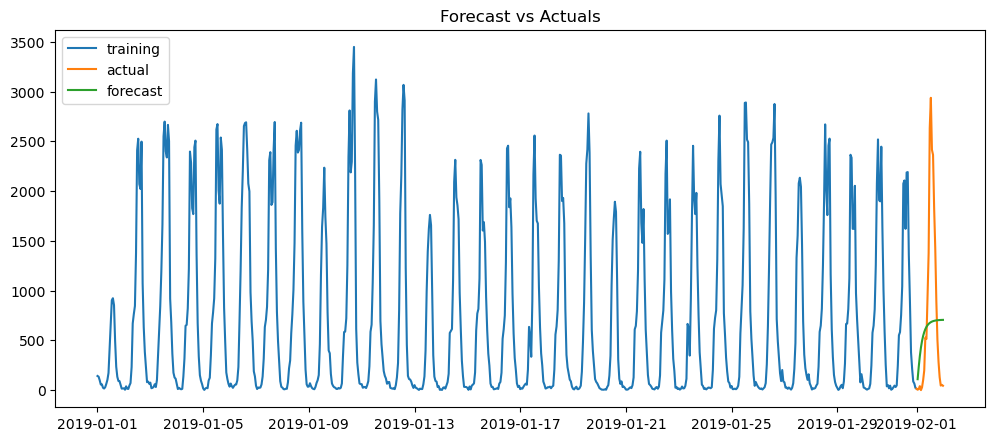

In [40]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_mnth_na, label='training')
plt.plot(test_mnth_na, label='actual')
plt.plot(fc_mnth, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [56]:
df_eg = df_footfall_stats_dict['Albion Street South'].copy()

In [57]:
df_day = df_eg.resample(rule='D')['Count'].sum()
df_day.info()
df_day.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 4376 entries, 2008-01-09 to 2020-01-01
Freq: D
Series name: Count
Non-Null Count  Dtype  
--------------  -----  
4376 non-null   float64
dtypes: float64(1)
memory usage: 68.4 KB


2008-01-09    50182.0
2008-01-10    40625.0
2008-01-11    79879.0
2008-01-12    55977.0
2008-01-13        0.0
Freq: D, Name: Count, dtype: float64

In [77]:
train_day = df_day.loc[pd.Timestamp('2019-01-01'):pd.Timestamp('2019-01-31')]
print(train_day)

2019-01-01     5772.0
2019-01-02    18182.0
2019-01-03    22553.0
2019-01-04    19855.0
2019-01-05    21701.0
2019-01-06    23597.0
2019-01-07    20711.0
2019-01-08    23002.0
2019-01-09    12952.0
2019-01-10    23346.0
2019-01-11    19977.0
2019-01-12    16448.0
2019-01-13     9908.0
2019-01-14    15312.0
2019-01-15    15378.0
2019-01-16    16060.0
2019-01-17    15343.0
2019-01-18    15762.0
2019-01-19    16013.0
2019-01-20    10398.0
2019-01-21    15519.0
2019-01-22    15410.0
2019-01-23    15421.0
2019-01-24    16790.0
2019-01-25    18985.0
2019-01-26    18655.0
2019-01-27    13340.0
2019-01-28    19471.0
2019-01-29    16583.0
2019-01-30    18140.0
2019-01-31    16616.0
Freq: D, Name: Count, dtype: float64


In [78]:
test_day = df_day.loc[pd.Timestamp('2019-02-01'): pd.Timestamp('2019-02-28')]
print(test_day)

2019-02-01    19281.0
2019-02-02    21913.0
2019-02-03    22928.0
2019-02-04    19583.0
2019-02-05    20590.0
2019-02-06    12630.0
2019-02-07    21940.0
2019-02-08    23686.0
2019-02-09    20861.0
2019-02-10    20343.0
2019-02-11    19711.0
2019-02-12    19270.0
2019-02-13    22585.0
2019-02-14    22436.0
2019-02-15    22150.0
2019-02-16    22467.0
2019-02-17    13199.0
2019-02-18    20177.0
2019-02-19    20650.0
2019-02-20    21241.0
2019-02-21    23081.0
2019-02-22    22435.0
2019-02-23    21164.0
2019-02-24    12315.0
2019-02-25    18165.0
2019-02-26    19745.0
2019-02-27    20419.0
2019-02-28    21247.0
Freq: D, Name: Count, dtype: float64


In [80]:
model_day = ARIMA(train_day, order=(1, 0, 1))  
model_day_fit = model_day.fit()
fc_day = model_day_fit.forecast(28)
print(fc_day)

2019-02-01    16982.706333
2019-02-02    16978.509850
2019-02-03    16976.145400
2019-02-04    16974.813184
2019-02-05    16974.062565
2019-02-06    16973.639640
2019-02-07    16973.401348
2019-02-08    16973.267086
2019-02-09    16973.191438
2019-02-10    16973.148815
2019-02-11    16973.124800
2019-02-12    16973.111269
2019-02-13    16973.103645
2019-02-14    16973.099349
2019-02-15    16973.096929
2019-02-16    16973.095565
2019-02-17    16973.094797
2019-02-18    16973.094364
2019-02-19    16973.094120
2019-02-20    16973.093983
2019-02-21    16973.093905
2019-02-22    16973.093862
2019-02-23    16973.093837
2019-02-24    16973.093823
2019-02-25    16973.093815
2019-02-26    16973.093811
2019-02-27    16973.093809
2019-02-28    16973.093807
Freq: D, Name: predicted_mean, dtype: float64


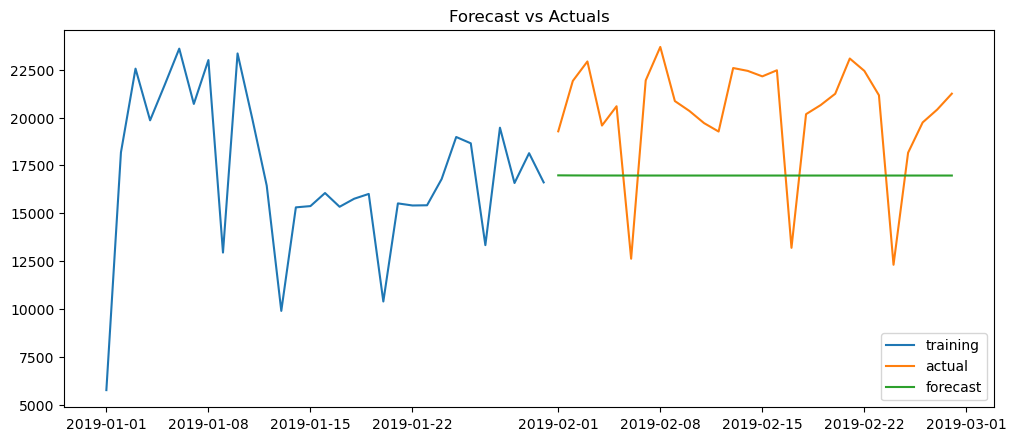

In [81]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_day, label='training')
plt.plot(test_day, label='actual')
plt.plot(fc_day, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [58]:
df_month = df_eg.resample(rule='M')['Count'].sum()
df_month.info()
df_month.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 145 entries, 2008-01-31 to 2020-01-31
Freq: M
Series name: Count
Non-Null Count  Dtype  
--------------  -----  
145 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


2008-01-31    226663.0
2008-02-29    161985.0
2008-03-31    193675.0
2008-04-30    219076.0
2008-05-31    179356.0
Freq: M, Name: Count, dtype: float64

In [82]:
train_month = df_month.loc[pd.Timestamp('2018-01-01'):pd.Timestamp('2019-01-01')]
train_month.tail(5)

2018-08-31    525572.0
2018-09-30    531537.0
2018-10-31    150978.0
2018-11-30    481675.0
2018-12-31    510958.0
Freq: M, Name: Count, dtype: float64

In [83]:
test_month = df_month.loc[pd.Timestamp('2019-01-01'): pd.Timestamp('2020-01-01')]
test_month.head(5)

2019-01-31    527200.0
2019-02-28    566212.0
2019-03-31    600717.0
2019-04-30    560690.0
2019-05-31    614263.0
Freq: M, Name: Count, dtype: float64

In [85]:
model_month = ARIMA(train_month, order=(1, 0, 1))  
model_month_fit = model_month.fit()
fc_month = model_month_fit.forecast(12)
print(fc_month)

2019-01-31    325629.853884
2019-02-28    427763.290363
2019-03-31    362768.656720
2019-04-30    404129.278158
2019-05-31    377808.628131
2019-06-30    394558.294692
2019-07-31    383899.312880
2019-08-31    390682.366910
2019-09-30    386365.836234
2019-10-31    389112.745959
2019-11-30    387364.695591
2019-12-31    388477.102038
Freq: M, Name: predicted_mean, dtype: float64


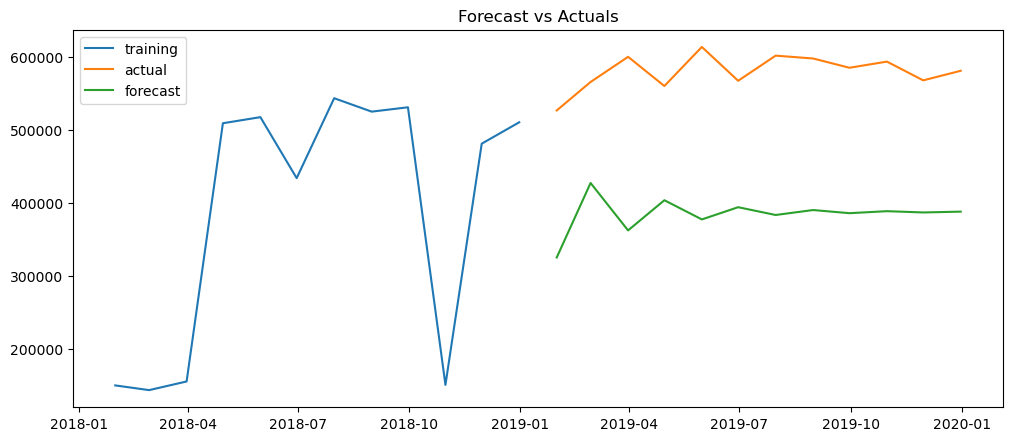

In [86]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_month, label='training')
plt.plot(test_month, label='actual')
plt.plot(fc_month, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

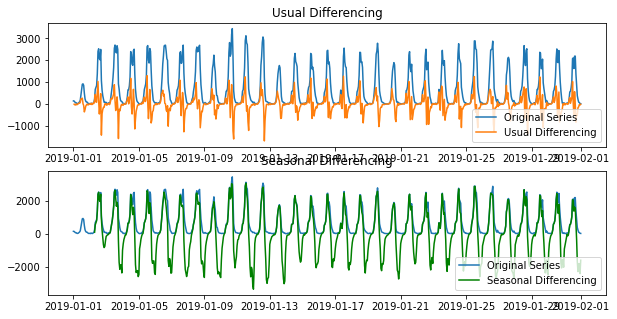

In [47]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5))
data = train_mnth_na
# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='lower right', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(31), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='lower right', fontsize=10)
plt.show()


In [87]:
import pmdarima as pm

In [88]:
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12849.094, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12847.184, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=7.09 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=10803.970, Time=7.27 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.49 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=8.90 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=11582.336, Time=12.39 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=22.25 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=20.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=10264.188, Time=6.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=3.07

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  745
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -5107.662
Date:                            Fri, 26 Aug 2022   AIC                          10227.324
Time:                                    03:37:46   BIC                          10254.906
Sample:                                         0   HQIC                         10237.963
                                            - 745                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2644     12.567      0.339      0.734     -20.366      28.895
ar.L1          0.6222      0.023     27.443      0.000       0.578       0.667
ma.L1          0.3470      0.028     12.510      0.000       0.293       0.401
ar.S.L12      -0.8535      0.022    -39.127      0.000      -0.896      -0.811
ma.S.L12      -0.2349      0.043     -5.485      0.000      -0.319      -0.151
sigma2      6.433e+04   2095.591     30.696      0.000    6.02e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              1202.23
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

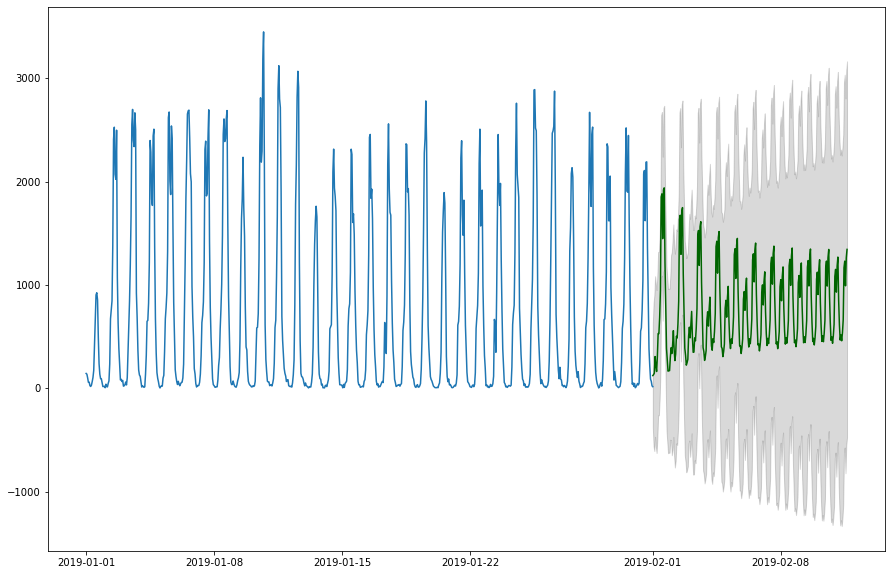

In [100]:
# Forecast
n_periods = 256
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='h')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()

In [ ]:
df_isales = pd.read_csv('C:/Users/medira/OneDrive - University of Leeds/Projects/AmbPop/AmbPopData/LCC_footfall_cleaned_2021.csv')

find the granuarity 
merge evergything 
Hourly - month, exo - mean month weather, internet sales, number of holidays
pandas correlation function try https://pandas.pyda3a.org/docs/reference/api/pandas.DataFrame.corr.html check if correlation > 0.3, then understand
validation: 
    train, 2009 - 2013, test, 1 yr
    train, 2010 - 2014, test 1 yr
    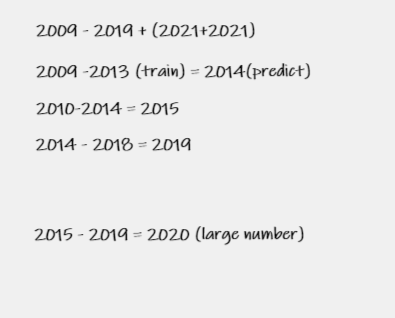
experimentation
2015 - 2019, 2020
    